In [1]:
import pandas as pd
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf
yf.pdr_override()
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def SaveData(df, filename):
    df.to_csv(r'data/'+filename+'.csv')
    
def GetData(ticker_list, start_date, end_date):
    print(ticker_list)
    df=[]
    for ticker in ticker_list:
        #print(ticker)
        data = pdr.get_data_yahoo(ticker, start=start_date, end=end_date, progress=False)
        data['Symbol'] = ticker 
        df.append(data)
    print("Data Download Completed")
    return df

In [3]:
# Tickers list to download
ticker_list=['NIO','AAPL', 'V', 'MSFT', 'BAC', 'JPM', 'NFLX']

# Dates
today = date.today()
start_date = '2020-01-02'
end_date = today

# Get the Data
df = GetData(ticker_list, start_date, end_date)
df = pd.concat(df)
df = df.reset_index()
df = df[['Date', 'Adj Close', 'Symbol']]
stocks = df.pivot('Date','Symbol','Adj Close').reset_index()
#SaveData(stocks,str(start_date)+'|'+str(end_date))

['NIO', 'AAPL', 'V', 'MSFT', 'BAC', 'JPM', 'NFLX']
Data Download Completed


In [4]:
stocks

Symbol,Date,AAPL,BAC,JPM,MSFT,NFLX,NIO,V
0,2020-01-02,73.840042,34.709141,136.145889,158.936279,329.809998,3.720000,189.950775
1,2020-01-03,73.122154,33.988472,134.349243,156.957260,325.899994,3.830000,188.440079
2,2020-01-06,73.704819,33.939774,134.242432,157.362961,335.829987,3.680000,188.032593
3,2020-01-07,73.358185,33.715782,131.960220,155.928177,330.750000,3.240000,187.535660
4,2020-01-08,74.538239,34.056641,132.989639,158.411835,339.260010,3.390000,190.745880
...,...,...,...,...,...,...,...,...
229,2020-11-27,116.589996,28.810434,121.220001,215.229996,491.359985,54.000000,211.000000
230,2020-11-30,119.050003,27.985575,117.879997,214.070007,490.700012,50.529999,210.350006
231,2020-12-01,122.720001,28.512293,119.739998,216.210007,504.579987,45.360001,211.199997
232,2020-12-02,123.080002,28.880001,122.040001,215.369995,503.380005,47.980000,210.179993


In [5]:
# Calculate daily log returns
daily_returns = np.log(stocks[ticker_list]/stocks[ticker_list].shift(-1))
daily_returns.insert(0, 'Date', stocks['Date'])

# Calculate daily standard deviation of returns
daily_std = np.std(daily_returns)

# Annualized daily standard deviation
std = daily_std * 252 ** 0.5

# Computing weekly volatility for log returns (90% sure it is wrong)
weekly_volatility = daily_returns.rolling(5).std()

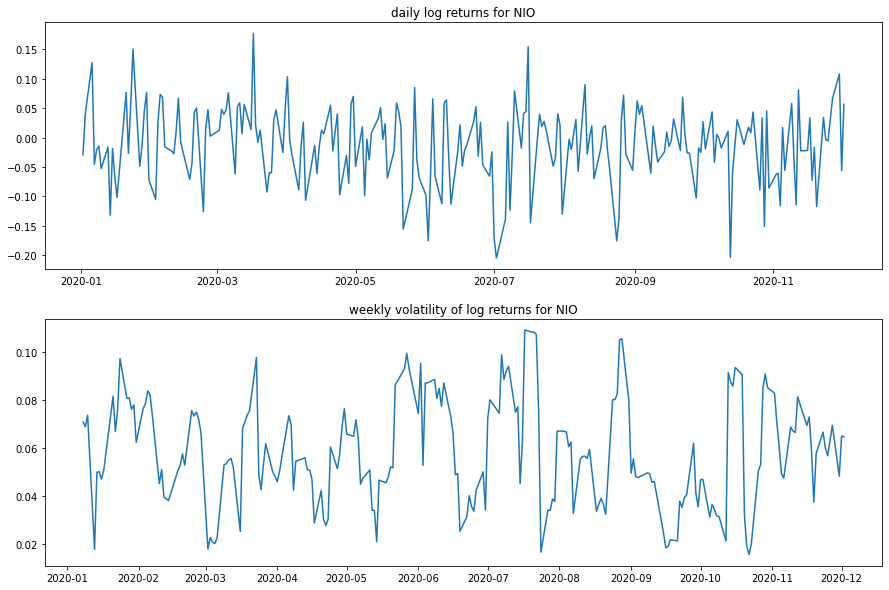

In [6]:
fig, ax = plt.subplots(2,1, figsize=(15,10))

ax[0].set_title('daily log returns for NIO')
ax[0].plot(daily_returns['Date'], daily_returns['NIO'])

ax[1].set_title('weekly volatility of log returns for NIO')
ax[1].plot(daily_returns['Date'], weekly_volatility['NIO'])

plt.show()

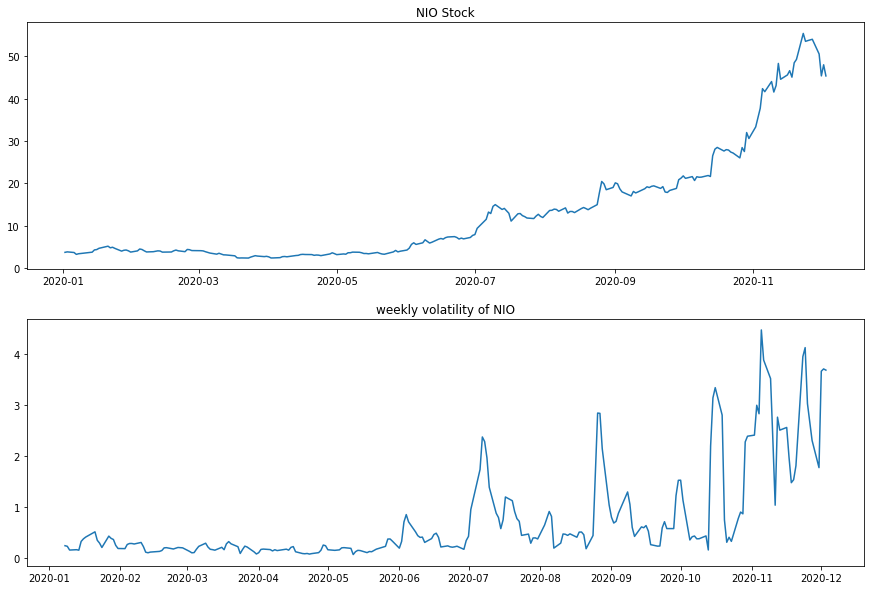

In [7]:
# Computing weekly volatility for the stocks
stocks_weekly_volatility = stocks.rolling(5).std()

fig, ax = plt.subplots(2,1, figsize=(15,10))

ax[0].set_title('NIO Stock')
ax[0].plot(stocks['Date'], stocks['NIO'])

ax[1].set_title('weekly volatility of NIO')
ax[1].plot(stocks['Date'], stocks_weekly_volatility['NIO'])

plt.show()

In [8]:
from arch import arch_model
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# First model : GARCH on log daily returns for NIO
returns = daily_returns[['Date','NIO']].dropna()

# AR1
ar_res = AutoReg(returns['NIO'], lags=[1], old_names=True).fit()
print(ar_res.summary())

#mod = arch_model(returns['NIO'], vol='garch', p=1, o=0, q=1, rescale=True)
#res = mod.fit()
#print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                    NIO   No. Observations:                  233
Model:                     AutoReg(1)   Log Likelihood                 309.729
Method:               Conditional MLE   S.D. of innovations              0.064
Date:                Fri, 04 Dec 2020   AIC                             -5.482
Time:                        13:40:20   BIC                             -5.438
Sample:                             1   HQIC                            -5.464
                                  233                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0095      0.004     -2.247      0.025      -0.018      -0.001
NIO.L1         0.1018      0.065      1.555      0.120      -0.027       0.230
                                    Roots           

In [9]:
# ARMA(1,1) on log returns
arma_res = ARIMA(returns['NIO'], order=(1,0,1)).fit()
print(arma_res.summary())

# GARCH(1,1) on residuals
garch_res = arch_model(arma_res.resid, vol='garch', p=1, o=0, q=1, rescale=False).fit(update_freq=5)
print(garch_res.summary())

                               SARIMAX Results                                
Dep. Variable:                    NIO   No. Observations:                  233
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 314.943
Date:                Fri, 04 Dec 2020   AIC                           -621.885
Time:                        13:40:20   BIC                           -608.081
Sample:                             0   HQIC                          -616.319
                                - 233                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0107      0.005     -2.344      0.019      -0.020      -0.002
ar.L1         -0.8041      0.089     -9.052      0.000      -0.978      -0.630
ma.L1          0.9276      0.057     16.296      0.0

---

Pytrends data:

In [38]:
from pytrends.request import TrendReq
import time

def GetTrends(keywords, period):
    
    startTime = time.time()
    
    # Connect to google trends
    # hl: host language (English)
    # timezone offset=360 (US CST)
    pytrends = TrendReq(hl='en-US', tz=360)

    #keywords list kw_list

    dataset = []

    for keyword in keywords:
        pytrends.build_payload(
        kw_list=[keyword],
        timeframe = period)
        
        data = pytrends.interest_over_time()
        
        if not data.empty:
            data = data.drop(labels=['isPartial'],axis='columns')
            dataset.append(data)

    executionTime = (time.time() - startTime)
    print('Execution time in sec.: ' + str(executionTime))

    #Creating the trends DataFrame
    g_trends = dataset[0]
    for data in dataset[1:]:
        g_trends = g_trends.merge(data, left_index=True, right_index=True)
        
    print("Google Trends data download success.")
    
    return g_trends
    
# -----------------------------------------------------------------------------------------------------------------
    
# is there better way to find these keywords ? (thi is hardcoded)
keywords = ['debt','loan','job','unemployment','economics','inflation','sell','bonds','gold','stocks','dow jones', \
            'crisis','finance','risk','leverage']
period = start_date +' '+ str(end_date)

g_trends = GetTrends(keywords, period=start_date +' '+ str(end_date))

Execution time in sec.: 5.8132007122039795
Google Trends data download success.


In [39]:
g_trends.head()

,debt,loan,job,unemployment,economics,inflation,sell,bonds,gold,stocks,dow jones,crisis,finance,risk,leverage
date,,,,,,,,,,,,,,,
2020-01-05,90,80,100,6,76,83,86,77,75,32,15,55,69,52,72
2020-01-12,91,76,97,6,84,96,84,77,66,31,14,79,66,54,67
2020-01-19,90,74,99,6,81,87,83,79,62,29,12,55,65,53,68
2020-01-26,91,75,96,6,84,89,83,82,61,31,16,47,71,58,69
2020-02-02,93,77,99,6,87,89,82,92,64,35,17,49,75,57,72


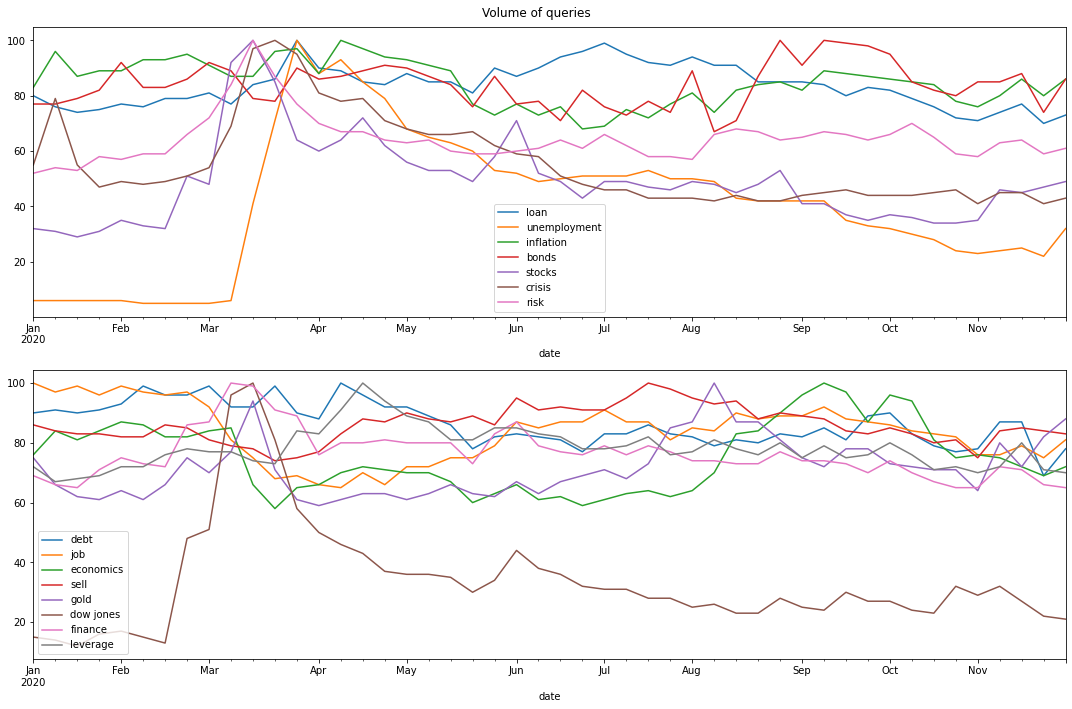

In [40]:
fig, axs = plt.subplots(2,figsize=(15,10))
axe = axs[0]
i=0
for ind, keyword in enumerate(keywords):
    i=i+1
    if i % 2 == 0:
        g_trends[keyword].plot(ax=axs[0], label=keyword)
        axs[0].legend(loc='best')
    else:
        g_trends[keyword].plot(ax=axs[1], label=keyword)
        axs[1].legend(loc='best')
        

fig.suptitle("Volume of queries")
fig.tight_layout()
plt.show()

Let's try and plot some data with the google trends data:

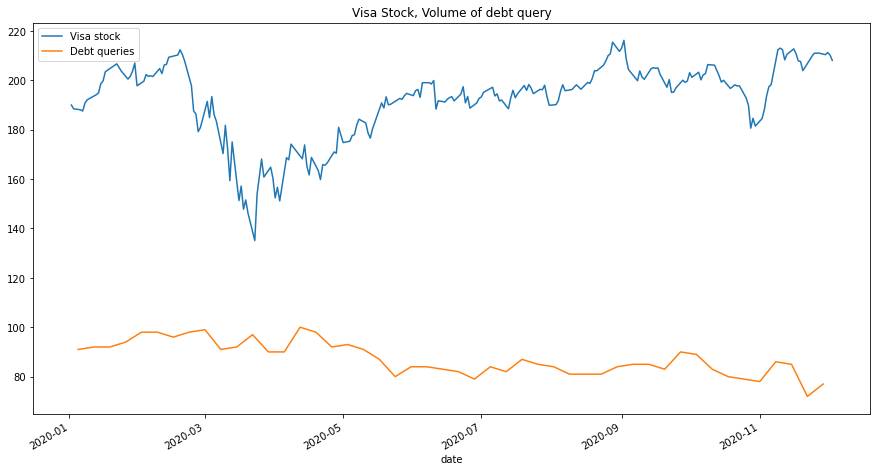

In [31]:
fig, ax = plt.subplots(figsize=(15,8))
ax.set_title('Visa Stock, Volume of debt query')
ax.plot(stocks['Date'], stocks['V'], label='Visa stock')
g_trends['debt'].plot(ax=ax, label='Debt queries')
ax.legend(loc='best')
plt.show()

- Après les OHs avec le TA:
    - On va travailler sur le log returns probablement en faisant un model qui prend en compte la volatilité.
    - On peut aussi modeliser la volatilitè avec trends, (data analysis et puis model)
    - On a utilisé un des articles pour decider les mots clès (kw_list), il y a des pics assez interessants.
    - GetData: permet de recuperer la data yfinance (M)
    - GetTrends: permet de recperer la data google trends (N)
    - ????